# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Read Data and Exploration

In [2]:
df = pd.read_csv('./data/train.csv')

X, y = df.drop(columns=['Survived']), df['Survived']

In [3]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [5]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looks like there are some NaN ages and cabin.

Simplifying the dataset a bit. The goal isn't to get the BEST predictor, but rather to play around with different preprocessing and scikit-learn's pipeline.

In [6]:
X = X[["Pclass", "Sex", "Age", "Fare", "Embarked"]]

# Train / Test Split

Separate 20% of the data and set aside for test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing Pipelines

### Numeric Pipeline

In [8]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked
692,3,male,NaN,56.4958,S
481,2,male,NaN,0.0000,S
527,1,male,NaN,221.7792,S
855,3,female,18.0,9.3500,S
801,2,female,31.0,26.2500,S


Age has missing values - need imputation.

Scale Fare and Pclass.

In [9]:
# Build pipline
numeric_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

### Categorical Pipeline

PClass is already ordinal-encoded.

Sex cannot be ordinal-encoded, must be OHE because no natural ordering.

Embarked must be OHE encoded as well because no natural ordering.

Imputer just to be sure.

In [10]:
categorical_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

### Combine Numeric and Categorical Into One Preprocessor

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("Numeric", numeric_pipeline, ["Pclass","Age", "Fare"]),
    ("Categorical", categorical_pipeline, ["Sex", "Embarked"])
])

# Full Pipelines

In [12]:
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit Pipelines

### Hyperparam Searching

In [13]:
log_reg_param_grid = {
    'log_reg__penalty': ['l2', None],  # Only penalties supported by lbfgs
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}

rf_param_grid = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 5, 10, 15, 20]
}

print("Performing Grid Search for Logistic Regression...")
log_reg_grid_search = GridSearchCV(
    log_reg_pipeline,
    log_reg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

log_reg_grid_search.fit(X_train, y_train)

print(f"Best Logistic Regression parameters: {log_reg_grid_search.best_params_}")
print(f"Best Logistic Regression CV score: {log_reg_grid_search.best_score_:.4f}")

print("Performing Grid Search for Random Forest...")
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest CV score: {rf_grid_search.best_score_:.4f}")

Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/jonathan/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jonathan/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jonathan/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jonathan/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jonathan/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jonathan/anac

Best Logistic Regression parameters: {'log_reg__C': 0.1, 'log_reg__penalty': 'l2'}
Best Logistic Regression CV score: 0.7978
Performing Grid Search for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest parameters: {'rf__max_depth': 5, 'rf__n_estimators': 200}
Best Random Forest CV score: 0.8217


In [14]:
best_log_reg = log_reg_grid_search.best_estimator_
best_rf = rf_grid_search.best_estimator_

# Evaluation on Test Set

In [15]:
y_pred_test_log_reg = best_log_reg.predict(X_test)
y_pred_test_rf = best_rf.predict(X_test)

In [16]:
score_log_reg = accuracy_score(y_test, y_pred_test_log_reg)
score_log_reg

0.776536312849162

In [17]:
score_rf = accuracy_score(y_test, y_pred_test_rf)
score_rf

0.7932960893854749

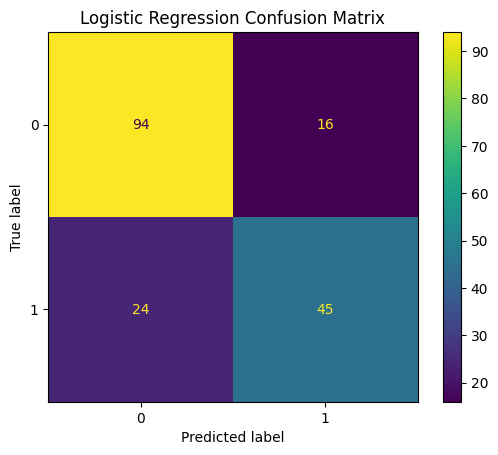

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_log_reg)
plt.title("Logistic Regression Confusion Matrix")

plt.show()

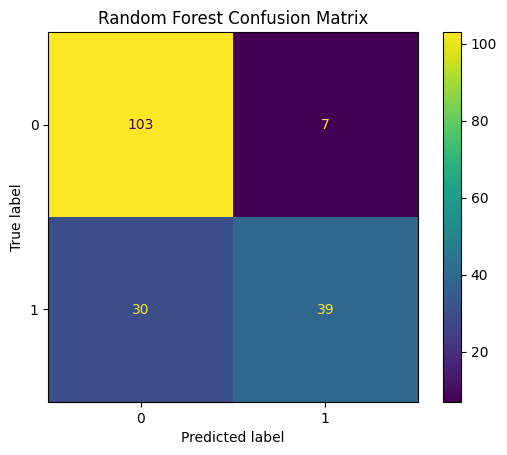

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)
plt.title("Random Forest Confusion Matrix")

plt.show()

# Comparison of Results

In [20]:
results = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        score_log_reg,
        score_rf
    ]
}

results

{'Model': ['Logistic Regression', 'Random Forest'],
 'Accuracy': [0.776536312849162, 0.7932960893854749]}